##  <font color = "cyan">MACHINE LEARNING: __Random Forest__ sur données rééquilibrées</font>
***

__<font color = "purple">But: Détecter les jours de pluie (Raintomorrow = 1), métriques suivies: rappel, précision (f1-score).</font>__

Résumé du notebook:

__1/ Cleaning:__ 
- Suppression des variables comprenant trop de NaN;
- Remplacement ou suppression des NaN des autres variables;
- Encoding (_comparé à dummification: pas d'impact sur résultats, mais plus pratique pour les analyses visuelles_);
- Pas Normalisation / Standardisation car les données conservées ont le même ordre de grandeur.

__2/ Machine Learning__
- Préparation des données : encoding des variables qualitatives
- Séparation des données
- Rééquilibrage: Undersampling +/- Oversampling
- Modèle retenu: __Random Forest__ 

__3/ Analyse de la performance et des résultats__
- Classification report
- Analyse des FN/FP


In [42]:
# IMPORTATION DES PACKAGES
import pandas as pd
import numpy as np

# VIZ
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ML: PRÉPARATION
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import RandomOverSampler

# ALGORITHME
from sklearn.ensemble import RandomForestClassifier

# ANALYSES
from sklearn import metrics



### <font color = "cyan">__1/ Cleaning__</font>

In [43]:
# IMPORTATION DU FICHIER
df = pd.read_csv("weatherAUS.csv")
pd.set_option('max_columns', None)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [52]:
df.isnull().sum()


Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [44]:
# 1/ SUPPRESSION DES VARIABLES PRESENTANT TROP DE NaN
df = df.drop(['Rainfall', 'WindGustSpeed', 'Cloud9am', 'Cloud3pm', 'Pressure9am', 'Pressure3pm', 
              'Evaporation', 'Sunshine'], axis = 1)


In [45]:
# 2/ VARIABLES RESTANTES: SUPPRESSION OU REMPLACEMENT DES NaN

# Suppression des NaN pour les variables 'RainToday' et 'RainTomorrow': 
df.dropna(axis = 0, how = 'any', subset = ['RainToday', 'RainTomorrow'], inplace = True)


# Pour le remplacement, on a besoin des dates (on supprimera ces colonnes par la suite): 
# Nouvelles variables pour les dates:
df['year'] = pd.to_datetime(df.Date).dt.year
df['month'] = pd.to_datetime(df.Date).dt.month
df['day'] = pd.to_datetime(df.Date).dt.day

df.drop('Date', axis = 1, inplace = True ) # suppression de la variable "Date" qui ne servira plus. 

In [46]:
# Min/MaxTemp; Temp9am/3pm; Humidity 9am/3pm: remplacement des NaN par moyenne par Station, par Mois, par Année:

mean_per_location = df.groupby(['Location','month', 'year']).mean().reset_index()

for row in df.itertuples():
    # Si l'attribut MinTemp de la ligne row est nul: on va remplacer dans df, à l'index row, la valeur de MinTemp, par la moyenne calculée dans mean_per_location, pour la station/mois/année correspondante.
    if pd.isna(row.MinTemp):
        df.loc[row.Index, 'MinTemp'] = mean_per_location[(mean_per_location['Location'] == row.Location) & (mean_per_location['month'] == row.month) & (mean_per_location['year'] == row.year)]['MinTemp'].values[0]
    
    # On applique le même raisonnement pour MaxTemp et autres...
    if pd.isna(row.MaxTemp):
        df.loc[row.Index, 'MaxTemp'] = mean_per_location[(mean_per_location['Location'] == row.Location) & (mean_per_location['month'] == row.month) & (mean_per_location['year'] == row.year)]['MaxTemp'].values[0]
    
    if pd.isna(row.Temp9am):
        df.loc[row.Index, 'Temp9am'] = mean_per_location[(mean_per_location['Location'] == row.Location) & (mean_per_location['month'] == row.month) & (mean_per_location['year'] == row.year)]['Temp9am'].values[0]
    
    if pd.isna(row.Temp9am):
        df.loc[row.Index, 'Temp3pm'] = mean_per_location[(mean_per_location['Location'] == row.Location) & (mean_per_location['month'] == row.month) & (mean_per_location['year'] == row.year)]['Temp3pm'].values[0]
    
    if pd.isna(row.Humidity9am):
        df.loc[row.Index, 'Humidity9am'] = mean_per_location[(mean_per_location['Location'] == row.Location) & (mean_per_location['month'] == row.month) & (mean_per_location['year'] == row.year)]['Humidity9am'].values[0]
    
    if pd.isna(row.Humidity3pm):
        df.loc[row.Index, 'Humidity3pm'] = mean_per_location[(mean_per_location['Location'] == row.Location) & (mean_per_location['month'] == row.month) & (mean_per_location['year'] == row.year)]['Humidity3pm'].values[0]
        

In [56]:
df.isna().sum()

Location           0
MinTemp            0
MaxTemp            0
WindGustDir     9163
WindDir9am      9660
WindDir3pm      3670
WindSpeed9am    1055
WindSpeed3pm    2531
Humidity9am      418
Humidity3pm     2386
Temp9am            0
Temp3pm         2427
RainToday          0
RainTomorrow       0
year               0
month              0
day                0
dtype: int64

In [47]:
print("Malgré le traitement, il reste encore des NaN pour 'Humidity' et 'Temp3pm'. Cela est sûrement dû à une présence de valeurs nulles sur un mois complet dans certaines stations. Décision de supprimer tous les NaN restants dans le df.")

# Suppression des NaN restants pour toutes les variables:  
df.dropna(axis = 0, subset = ['Humidity9am', 'Humidity3pm', 'Temp3pm', 'WindSpeed9am', 'WindSpeed3pm','WindGustDir', 'WindDir9am', 'WindDir3pm'], inplace = True)


Malgré le traitement, il reste encore des NaN pour 'Humidity' et 'Temp3pm'. Cela est sûrement dû à une présence de valeurs nulles sur un mois complet dans certaines stations. Décision de supprimer tous les NaN restants dans le df.


In [58]:
df.isna().sum()


Location        0
MinTemp         0
MaxTemp         0
WindGustDir     0
WindDir9am      0
WindDir3pm      0
WindSpeed9am    0
WindSpeed3pm    0
Humidity9am     0
Humidity3pm     0
Temp9am         0
Temp3pm         0
RainToday       0
RainTomorrow    0
year            0
month           0
day             0
dtype: int64

#### <font color = "cyan">__Bilan cleaning__</font>

In [59]:
# Stations supprimées: 
Loc = ['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree','Newcastle', 'NorahHead', 'NorfolkIsland', 
       'Penrith', 'Richmond', 'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown', 'Wollongong', 'Canberra', 
       'Tuggeranong', 'MountGinini', 'Ballarat', 'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura', 
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns', 'GoldCoast', 'Townsville', 'Adelaide', 
       'MountGambier', 'Nuriootpa', 'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport', 'Perth', 
       'SalmonGums', 'Walpole', 'Hobart', 'Launceston', 'AliceSprings', 'Darwin', 'Katherine', 'Uluru']

stat_erased = []

for loc in Loc:
    if loc not in df.Location.unique():
        stat_erased.append(loc)

df_saved = pd.read_csv("weatherAUS.csv")

print(f"\nNombre d'entrées finales, non nulles: {len(df)} \n Stations supprimées {stat_erased}")
print("Perte de %.2f pourcents des données, perte de deux stations sur 49"%(( len(df_saved) - len(df) ) / len(df_saved) * 100))



Nombre d'entrées finales, non nulles: 122649 
 Stations supprimées ['Newcastle', 'Albany']
Perte de 15.68 pourcents des données, perte de deux stations sur 49


In [48]:
# Suppression des variables relatives à la date ou à la station, car ne serviront pas pour le reste du notebook.
df.drop(['Location', 'year', 'month', 'day'], axis = 1, inplace = True)


### <font color = "cyan">__2/ Machine Learning: Random Forest__</font>

#### <font color = "purple">__Préparation des données__</font>

In [49]:
# GESTION DES VAR QUAL (ENCODING)

# RainToday et RainTomorrow:
df.replace(['Yes', 'No'], [1, 0], inplace = True)


In [50]:
# POUR LA DIRECTION DU VENT: 

#Si get_dummies: 16 directions * 3 = 48 colonnes
# On décide d'utiliser LabelEncoder (les deux méthodes ont été comparées et le LabelEncoder ne semble pas 
#avoir d'impact négatif)

wind = df['WindGustDir'].unique()

label = preprocessing.LabelEncoder() 

labels = label.fit_transform(wind)

df.replace(wind, labels, inplace = True)

df.info()

print(wind)

# *****
#df['WindGustDir'].unique()
#df = pd.get_dummies(df, prefix=None) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122649 entries, 0 to 145458
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   MinTemp       122649 non-null  float64
 1   MaxTemp       122649 non-null  float64
 2   WindGustDir   122649 non-null  int64  
 3   WindDir9am    122649 non-null  int64  
 4   WindDir3pm    122649 non-null  int64  
 5   WindSpeed9am  122649 non-null  float64
 6   WindSpeed3pm  122649 non-null  float64
 7   Humidity9am   122649 non-null  float64
 8   Humidity3pm   122649 non-null  float64
 9   Temp9am       122649 non-null  float64
 10  Temp3pm       122649 non-null  float64
 11  RainToday     122649 non-null  int64  
 12  RainTomorrow  122649 non-null  int64  
dtypes: float64(8), int64(5)
memory usage: 13.1 MB
['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' 'ENE' 'SSE' 'S' 'NW' 'SE' 'ESE'
 'E' 'SSW']


In [51]:
df.describe().round(1)


,MinTemp,MaxTemp,WindGustDir,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,122649.0,122649.0,122649.0,122649.0,122649.0,122649.0,122649.0,122649.0,122649.0,122649.0,122649.0,122649.0,122649.0
mean,12.4,23.4,7.7,7.3,7.8,15.0,19.2,67.7,50.8,17.2,21.9,0.2,0.2
std,6.3,7.2,4.7,4.6,4.6,8.3,8.6,19.1,21.0,6.5,7.0,0.4,0.4
min,-8.5,-4.8,0.0,0.0,0.0,2.0,2.0,0.0,0.0,-7.2,-5.4,0.0,0.0
25%,7.8,18.1,4.0,3.0,4.0,9.0,13.0,56.0,36.0,12.5,16.7,0.0,0.0
50%,12.2,22.9,8.0,7.0,8.0,13.0,19.0,69.0,51.0,16.9,21.4,0.0,0.0
75%,17.0,28.5,12.0,11.0,12.0,20.0,24.0,82.0,65.0,21.8,26.8,0.0,0.0
max,33.9,48.1,15.0,15.0,15.0,87.0,87.0,100.0,100.0,40.2,46.7,1.0,1.0


In [64]:
df.RainTomorrow.value_counts(normalize = True)

0    0.778979
1    0.221021
Name: RainTomorrow, dtype: float64

In [65]:
df.RainToday.value_counts()

0    95156
1    27493
Name: RainToday, dtype: int64

#### <font color = "purple">__Séparation des données__</font>

In [52]:
data, target = df.drop('RainTomorrow', axis = 1), df['RainTomorrow']

# On sépare les données en un ensemble d'apprentissage et un ensemble de test, avec le ratio 80/20
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)


In [53]:
# RANDOM FOREST

# Instanciation d'un modèle
rf1 = RandomForestClassifier()

# Rééquilibrage des données: 3 possibilités testées

over = RandomOverSampler(sampling_strategy = 0.6) # Fraction 60/40 
under = RandomUnderSampler() 


# a) Over puis under Sample
X_ov, y_ov = over.fit_resample(X_train, y_train) 
print(y_ov.value_counts())

X_res, y_res = under.fit_resample(X_ov, y_ov) 
print(y_res.value_counts())


# b) Seulement un under Sample:
X_un, y_un = under.fit_resample(X_train, y_train)
print(y_un.value_counts())

# c) Seulement avec Over (X_ov, y_ov)

0    76444
1    45866
Name: RainTomorrow, dtype: int64
0    45866
1    45866
Name: RainTomorrow, dtype: int64
0    21675
1    21675
Name: RainTomorrow, dtype: int64


#### <font color = "purple">__Entraînement du modèle & Evaluation de la performance__</font>

In [54]:
# ENTRAÎNEMENT DU MODÈLE avec solution a)Over puis Under Sample
rf1.fit(X_res, y_res)


# EVALUATION DE LA PERFORMANCE
y_pred1 = rf1.predict(X_test)

print(pd.crosstab(y_test, y_pred1, rownames = ['Classe réelle'], colnames = ['Classe prédite']))


Classe prédite      0     1
Classe réelle              
0               16756  2341
1                1988  3445


In [71]:
print(metrics.classification_report(y_test, y_pred1))


              precision    recall  f1-score   support

           0       0.89      0.88      0.89     19070
           1       0.61      0.63      0.62      5460

    accuracy                           0.83     24530
   macro avg       0.75      0.76      0.75     24530
weighted avg       0.83      0.83      0.83     24530



In [72]:
# ENTRAÎNEMENT DU MODÈLE avec solution b) UnderSample
rf2 = RandomForestClassifier()

rf2.fit(X_un, y_un)


# EVALUATION DE LA PERFORMANCE
y_pred2 = rf2.predict(X_test)

#print(pd.crosstab(y_test, y_pred2, rownames = ['Classe réelle'], colnames = ['Classe prédite']))

print(metrics.classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85     19070
           1       0.51      0.76      0.61      5460

    accuracy                           0.78     24530
   macro avg       0.71      0.77      0.73     24530
weighted avg       0.83      0.78      0.80     24530



In [74]:
# ENTRAÎNEMENT DU MODÈLE avec solution c) OverSample
rf3 = RandomForestClassifier()

rf3.fit(X_ov, y_ov)


# EVALUATION DE LA PERFORMANCE
y_pred3 = rf3.predict(X_test)

#print(pd.crosstab(y_test, y_pred3, rownames = ['Classe réelle'], colnames = ['Classe prédite']))

print(metrics.classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     19070
           1       0.70      0.50      0.59      5460

    accuracy                           0.84     24530
   macro avg       0.78      0.72      0.74     24530
weighted avg       0.83      0.84      0.83     24530



#### <font color = "purple">__Analyses diverses: Feature Importance, Visualisation__</font>

In [15]:
# FEATURE_IMPORTANCE:

importances = rf1.feature_importances_

impor=pd.DataFrame(data=(importances), index=data.columns, columns=['Importance'])
impor=impor.sort_values(by='Importance', ascending=False)

impor.head(15)

,Importance
Humidity3pm,0.249362
Humidity9am,0.092487
MinTemp,0.087973
Temp3pm,0.085683
Temp9am,0.078211
MaxTemp,0.077891
WindSpeed3pm,0.062864
WindSpeed9am,0.054236
RainToday,0.053383
WindDir9am,0.053149


In [55]:
# ANALYSE DES FN et FP

# y_pred to DataFrame, index of y_test to join to X_test df
predictions = pd.DataFrame(y_pred1).set_index(y_test.index)
predictions.columns = ['predictions']

df_rain = [y_test, predictions]

# New df with X_test, y_test & y_pred
df_compare = X_test.join(other = df_rain).reset_index()

#predictions.value_counts()
#df_compare['predictions'].value_counts()


df_compare.drop('index', axis = 1,  inplace = True)


In [56]:
df_compare

,MinTemp,MaxTemp,WindGustDir,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,predictions
0,7.1,14.6,6,14,0,15.0,11.0,70.0,57.0,9.8,14.1,0,0,0
1,11.1,20.1,3,3,8,9.0,11.0,85.0,70.0,15.4,18.2,0,0,0
2,19.5,24.3,5,7,3,9.0,9.0,95.0,86.0,21.6,23.8,1,1,1
3,6.0,16.2,13,6,13,9.0,15.0,86.0,55.0,10.3,15.4,0,0,0
4,18.6,20.8,13,8,15,9.0,15.0,76.0,93.0,19.9,16.9,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24525,13.7,29.9,11,9,15,13.0,15.0,34.0,19.0,20.9,28.3,0,0,0
24526,10.6,20.2,10,2,12,17.0,7.0,57.0,45.0,14.3,18.9,0,0,0
24527,9.2,12.6,13,15,13,31.0,26.0,92.0,89.0,10.4,11.4,1,1,1
24528,9.1,25.8,3,6,3,2.0,9.0,98.0,45.0,12.1,24.9,0,0,0


In [57]:
# SUBDATAFRAMES:
VN = df_compare[(df_compare['RainTomorrow'] == 0) & (df_compare['predictions'] == 0)]
VP = df_compare[(df_compare['RainTomorrow'] == 1) & (df_compare['predictions'] == 1)] # intéressant à analyser
FP = df_compare[(df_compare['RainTomorrow'] == 0) & (df_compare['predictions'] == 1)] #intéressant à analyser
FN = df_compare[(df_compare['RainTomorrow'] == 1) & (df_compare['predictions'] == 0)]

In [58]:
print('Faux positifs:', len(FP))
print('Vrais positifs:', len(VP))
print('Faux négatifs:', len(FN))
print('Vrais négatifs:', len(VN))

Faux positifs: 2341
Vrais positifs: 3445
Faux négatifs: 1988
Vrais négatifs: 16756


In [60]:
VP.describe().round(1)

,MinTemp,MaxTemp,WindGustDir,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,predictions
count,3445.0,3445.0,3445.0,3445.0,3445.0,3445.0,3445.0,3445.0,3445.0,3445.0,3445.0,3445.0,3445.0,3445.0
mean,13.5,19.8,8.4,7.7,8.3,17.8,21.2,82.2,78.3,16.3,17.7,0.6,1.0,1.0
std,6.2,6.5,4.5,4.5,4.5,9.2,9.8,13.5,13.9,6.3,6.2,0.5,0.0,0.0
min,-7.0,-4.1,0.0,0.0,0.0,2.0,2.0,15.0,14.0,-5.2,-3.7,0.0,1.0,1.0
25%,8.7,14.9,5.0,4.0,5.0,11.0,13.0,74.0,69.0,11.5,13.2,0.0,1.0,1.0
50%,13.0,18.9,9.0,7.0,8.0,17.0,20.0,85.0,80.0,15.6,16.9,1.0,1.0,1.0
75%,18.1,24.1,13.0,12.0,12.0,24.0,28.0,93.0,89.0,20.7,21.5,1.0,1.0,1.0
max,28.8,43.0,15.0,15.0,15.0,69.0,65.0,100.0,100.0,34.3,39.9,1.0,1.0,1.0


In [61]:
FN.describe().round(1)

,MinTemp,MaxTemp,WindGustDir,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,predictions
count,1988.0,1988.0,1988.0,1988.0,1988.0,1988.0,1988.0,1988.0,1988.0,1988.0,1988.0,1988.0,1988.0,1988.0
mean,12.8,23.2,7.8,7.2,7.6,14.7,20.0,69.4,52.5,17.3,21.7,0.2,1.0,0.0
std,6.5,7.3,4.6,4.5,4.6,8.4,8.6,17.4,15.7,6.7,7.0,0.4,0.0,0.0
min,-6.3,-0.3,0.0,0.0,0.0,2.0,2.0,1.0,1.0,-3.1,-1.7,0.0,1.0,0.0
25%,7.9,17.8,4.0,3.0,4.0,9.0,13.0,60.0,43.0,12.2,16.6,0.0,1.0,0.0
50%,12.6,22.6,8.0,7.0,7.0,13.0,19.0,70.0,55.0,16.9,21.1,0.0,1.0,0.0
75%,17.8,28.2,12.0,11.0,12.0,19.0,26.0,81.0,63.0,22.1,26.4,0.0,1.0,0.0
max,29.3,44.9,15.0,15.0,15.0,63.0,63.0,100.0,100.0,36.1,43.6,1.0,1.0,0.0


<font color= "purple">__Comparaison des variables quantitatives entre les FN et les VP (valeurs réelles: jour de pluie)__</font>

Dans ces graphes, on considère tous les jours réels de pluie. Les box bleues correspondent à de fausses prédictions (FN) tandis que les oranges sont de bonnes prédictions (VP)


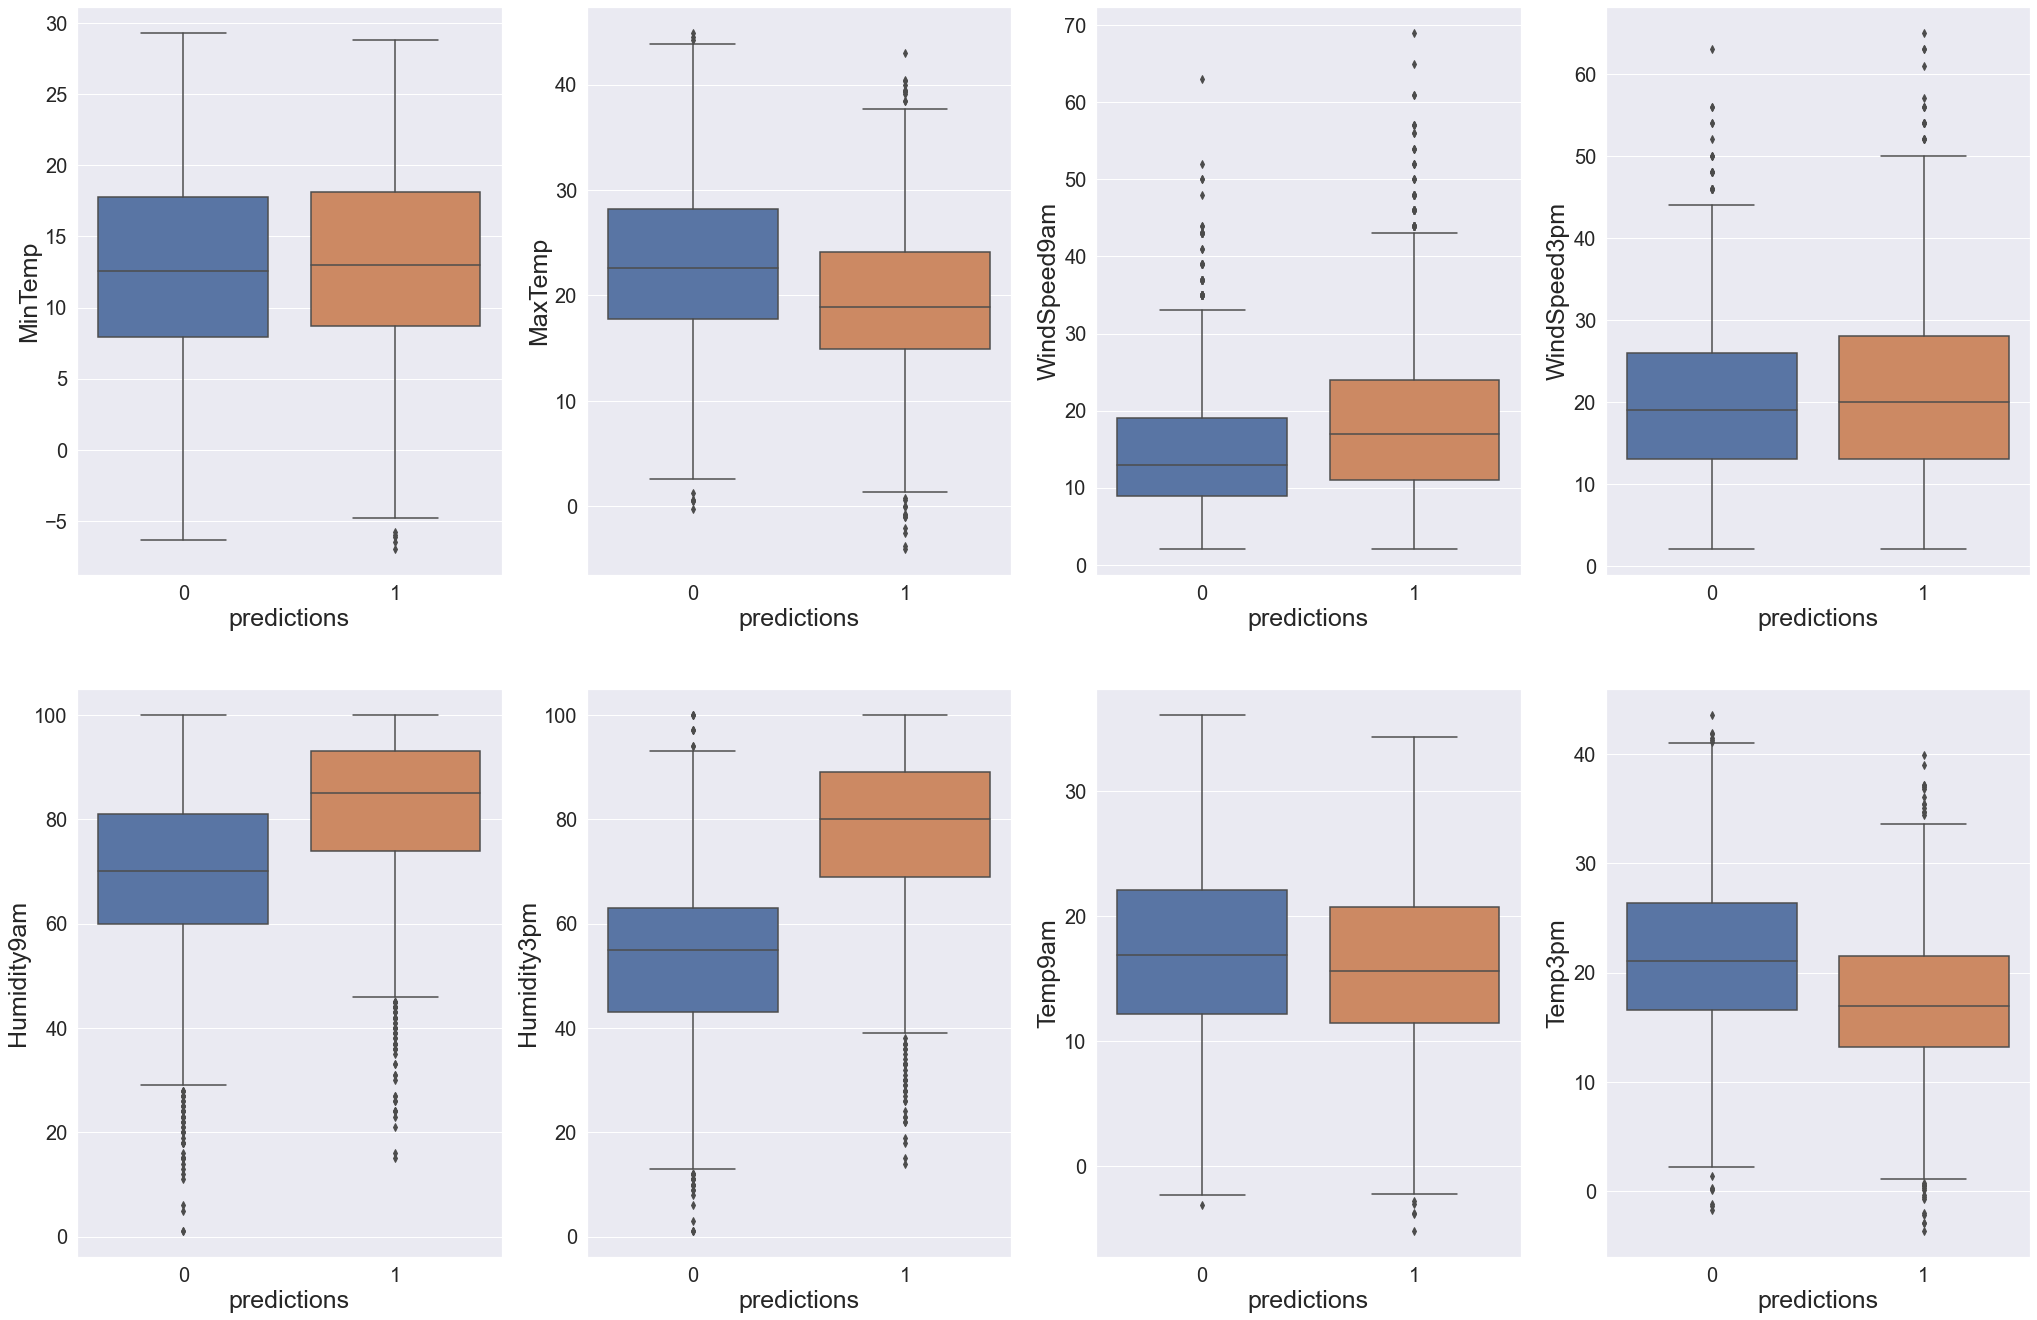

In [80]:
FN_VP = pd.concat([FN, VP], axis = 0)

print("Dans ces graphes, on considère tous les jours réels de pluie. Les box bleues correspondent à de fausses prédictions (FN) tandis que les oranges sont de bonnes prédictions (VP)")
fig, axes = plt.subplots(2, 4, figsize=(35, 23))

plt.subplot(241)
sns.boxplot(ax=axes[0, 0], data=FN_VP, x='predictions', y='MinTemp')
plt.xticks(size = 20)
plt.yticks(size = 20);

plt.subplot(242)
sns.boxplot(ax=axes[0, 1], data=FN_VP, x='predictions', y='MaxTemp')
plt.xticks(size = 20)
plt.yticks(size = 20);

plt.subplot(243)
sns.boxplot(ax=axes[0, 2], data=FN_VP, x='predictions', y='WindSpeed9am')
plt.xticks(size = 20)
plt.yticks(size = 20);


plt.subplot(244)
sns.boxplot(ax=axes[0, 3], data=FN_VP, x='predictions', y='WindSpeed3pm')
plt.xticks(size = 20)
plt.yticks(size = 20);

plt.subplot(245)
sns.boxplot(ax=axes[1, 0], data=FN_VP, x='predictions', y='Humidity9am')
plt.xticks(size = 20)
plt.yticks(size = 20);

plt.subplot(246)
sns.boxplot(ax=axes[1, 1], data=FN_VP, x='predictions', y='Humidity3pm')
plt.xticks(size = 20)
plt.yticks(size = 20);

plt.subplot(247)
sns.boxplot(ax=axes[1, 2], data=FN_VP, x='predictions', y='Temp9am')
plt.xticks(size = 20)
plt.yticks(size = 20);

plt.subplot(248)
sns.boxplot(ax=axes[1, 3], data=FN_VP, x='predictions', y='Temp3pm');
plt.xticks(size = 20)
plt.yticks(size = 20);




<font color = "purple">__Comparaison des variables qualitatives (direction du vent) entre les FN et les VP (valeurs réelles: jour de pluie)__</font>

Il serait mieux d'afficher les différences / analyses stats pour plus d'interprétabilité
A première vue: il a globalement plus de rafales de vents dans les FN -> cette variable perturbe peut-être le modèle
Deux vents ressortent plus que les autres dans les VP, moins flagrants dans les FN...


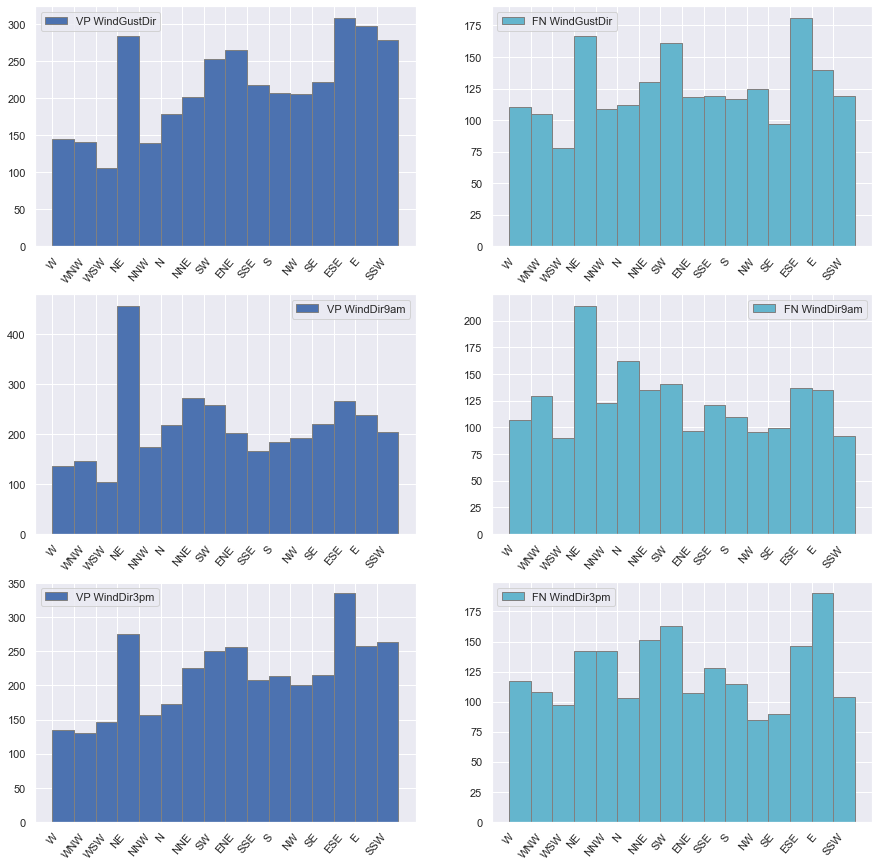

In [87]:
VP1 = FN_VP[FN_VP['predictions'] == 1]
FN1 = FN_VP[FN_VP['predictions'] == 0]

print("Il serait mieux d'afficher les différences / analyses stats pour plus d'interprétabilité")
print("A première vue: il a globalement plus de rafales de vents dans les FN -> cette variable perturbe peut-être le modèle") 
print("Deux vents ressortent plus que les autres dans les VP, moins flagrants dans les FN...")

plt.figure(figsize = (15, 15))

# WINDGUSTDIR
plt.subplot(3,2,1)
plt.hist(VP1['WindGustDir'], bins = range(0, 17), color = 'b', edgecolor='grey', label = "VP WindGustDir"); #rwidth = 0.8
plt.xticks(range(0, 16), wind, rotation = 50);
plt.legend();

plt.subplot(3,2,2)
plt.hist(FN1['WindGustDir'], bins = range(0, 17), color = 'c', edgecolor='grey', label = 'FN WindGustDir'); #rwidth = 0.8
plt.xticks(range(0, 16), wind, rotation = 50);
plt.legend();


# WindDir9am
plt.subplot(3,2,3)
plt.hist(VP1['WindDir9am'], bins = range(0, 17), color = 'b', edgecolor='grey', label = 'VP WindDir9am'); #rwidth = 0.8
plt.xticks(range(0, 16), wind, rotation = 50);
plt.legend();

plt.subplot(3,2,4)
plt.hist(FN1['WindDir9am'], bins = range(0, 17), color = 'c', edgecolor='grey', label = 'FN WindDir9am'); #rwidth = 0.8
plt.xticks(range(0, 16), wind, rotation = 50);
plt.legend();


#WindDir3pm
plt.subplot(3,2,5)
plt.hist(VP1['WindDir3pm'], bins = range(0, 17), color = 'b', edgecolor='grey', label = 'VP WindDir3pm'); #rwidth = 0.8
plt.xticks(range(0, 16), wind, rotation = 50);
plt.legend();

plt.subplot(3,2,6)
plt.hist(FN1['WindDir3pm'], bins = range(0, 17), color = 'c', edgecolor='grey', label = 'FN WindDir3pm'); #rwidth = 0.8
plt.xticks(range(0, 16), wind, rotation = 50);
plt.legend();

### <font color = "cyan">Amélioration via la recherche des meilleurs paramètres</font>
***

Application d'un RandomizedSearchCV pour trouver la meilleure grille de paramètres (échelles de valeurs), puis application d'un GridSearchCV avec la meilleure grille trouvée, pour trouver les meilleurs paramètres.

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 15)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [36]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
#rf = RandomForestRegressor()
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_res, y_res)

/Users/lise/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500]})

In [37]:
# Affichage des meilleurs paramètres: 
rf_random.best_params_


{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': False}

In [39]:
# Récupération des meilleurs paramètres pour faire tourner le gridsearch

param_grid = {'bootstrap': [True],
    'max_depth': [70, 80, 100],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [1, 2],
    'n_estimators': [300, 500, 800, 900]}


grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1)

# Fit the grid search to the data
grid.fit(X_res, y_res)

grid.best_params_

/Users/lise/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/lise/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
144 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lise/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lise/opt

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [40]:
# Modelisation avec meilleurs paramètres:
rf_opt = RandomForestClassifier(bootstrap = True, max_depth = 100, max_features = 'sqrt',
                                min_samples_leaf = 1, min_samples_split= 2, n_estimators = 500)

rf_opt.fit(X_res, y_res)

y_pred_opt = rf_opt.predict(X_test)

print(metrics.classification_report(y_test, y_pred_opt))


              precision    recall  f1-score   support

           0       0.90      0.88      0.89     19152
           1       0.60      0.63      0.61      5378

    accuracy                           0.83     24530
   macro avg       0.75      0.76      0.75     24530
weighted avg       0.83      0.83      0.83     24530

